# Nhận diện biển số xe với ảnh bị làm mờ
Notebook này thử nghiệm nhận diện biển số xe khi ảnh đầu vào bị làm mờ (blur) trước khi nhận diện bằng EasyOCR.

In [1]:
# Import thư viện cần thiết
from PIL import ImageFont, ImageDraw, Image
import numpy as np
import cv2
from easyocr import Reader
import matplotlib.pyplot as plt

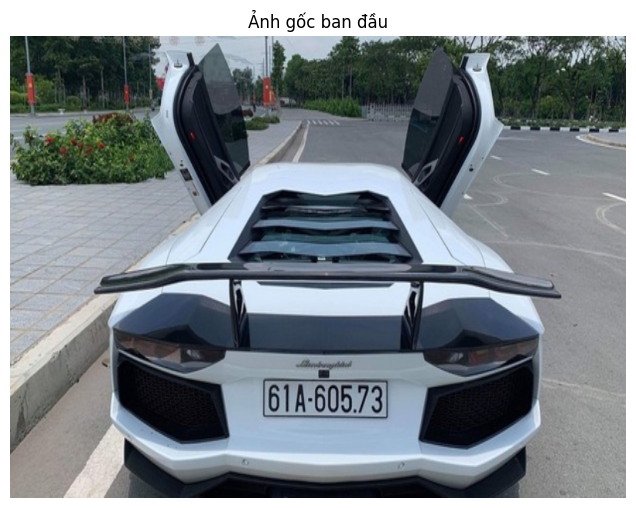

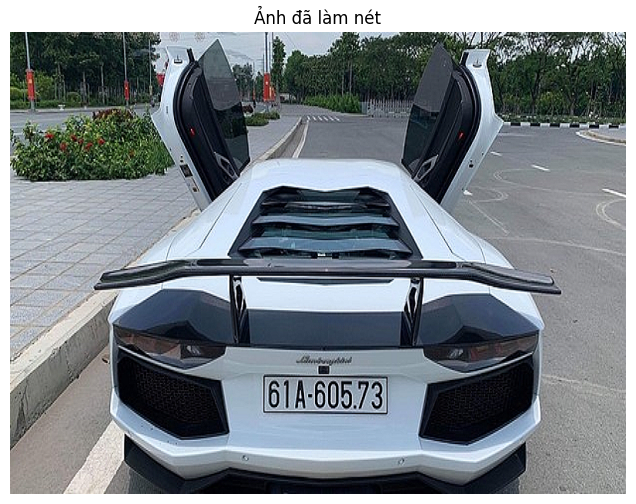

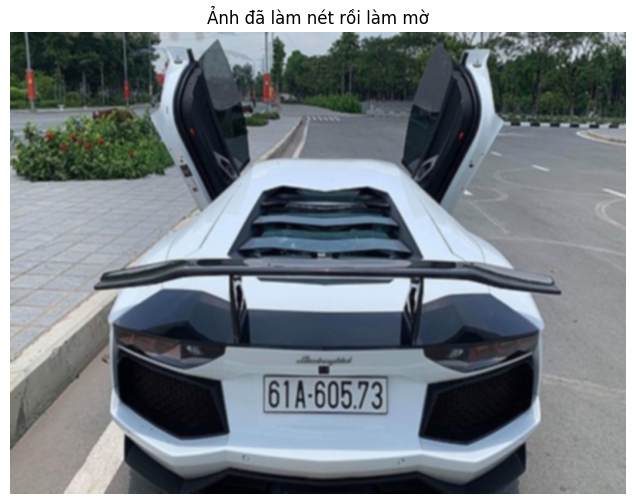

In [2]:
# Load ảnh gốc, hiển thị và làm nét trước khi làm mờ
img = cv2.imread('./images/image5.jpg')  # Thay bằng ảnh bạn muốn test
img = cv2.resize(img, (800, 600))
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh gốc ban đầu')
plt.axis('off')
plt.show()
# Làm nét ảnh gốc trước khi làm mờ
sharp_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
sharpened_img = cv2.filter2D(img, -1, sharp_kernel)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(sharpened_img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đã làm nét')
plt.axis('off')
plt.show()
# Làm mờ vừa phải trên ảnh đã làm nét
blurred_img = cv2.GaussianBlur(sharpened_img, (7, 7), 0)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(blurred_img, cv2.COLOR_BGR2RGB))
plt.title('Ảnh đã làm nét rồi làm mờ')
plt.axis('off')
plt.show()

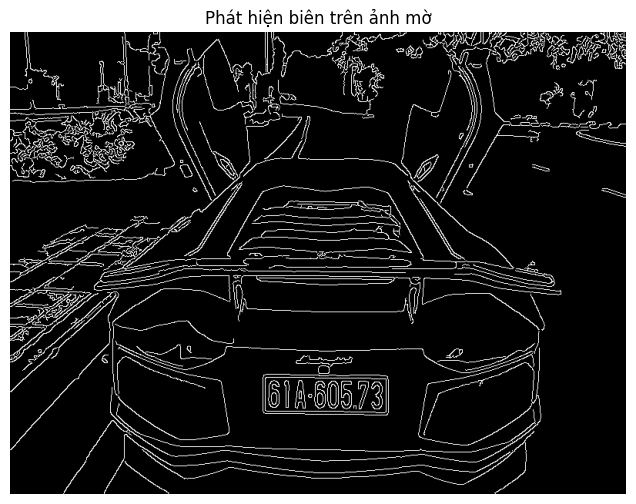

In [3]:
# Chuyển sang ảnh xám và phát hiện biên
grayscale = cv2.cvtColor(blurred_img, cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(grayscale, 10, 200)
plt.figure(figsize=(8,6))
plt.imshow(edged, cmap='gray')
plt.title('Phát hiện biên trên ảnh mờ')
plt.axis('off')
plt.show()

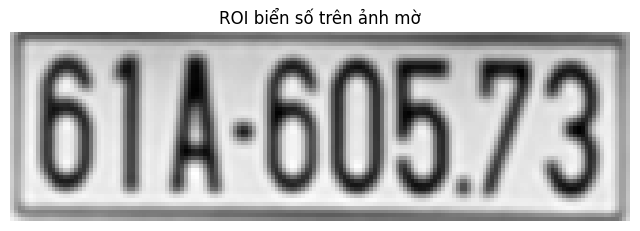

In [4]:
# Tìm contour và nhận diện biển số trên ảnh mờ
contours, _ = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:5]
number_plate_shape = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:
        number_plate_shape = approx
        break
if number_plate_shape is not None:
    (x, y, w, h) = cv2.boundingRect(number_plate_shape)
    number_plate = grayscale[y:y+h, x:x+w]
    plt.figure(figsize=(8,6))
    plt.imshow(number_plate, cmap='gray')
    plt.title('ROI biển số trên ảnh mờ')
    plt.axis('off')
    plt.show()
else:
    number_plate = None
    print('Không tìm thấy biển số trên ảnh mờ!')

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\cuda\__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


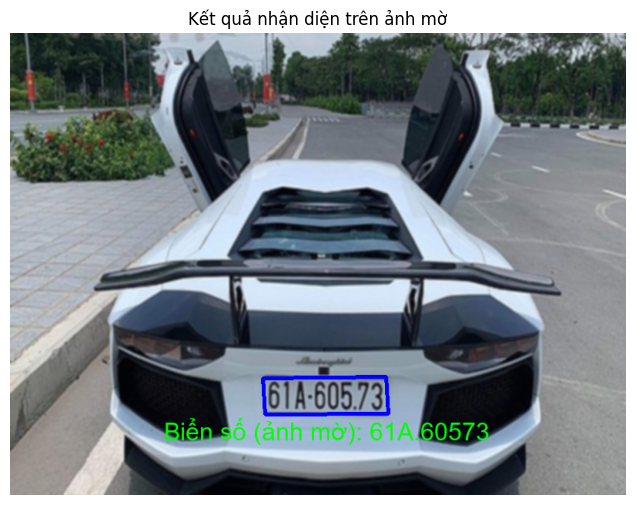

In [5]:
# Nhận diện ký tự bằng EasyOCR trên ảnh mờ
if number_plate is not None:
    reader = Reader(['en'])
    detection = reader.readtext(number_plate)
else:
    detection = []
img_result = blurred_img.copy()
if number_plate_shape is not None:
    cv2.drawContours(img_result, [number_plate_shape], -1, (255, 0, 0), 3)
if len(detection) == 0:
    text = "Không thấy bảng số xe trên ảnh mờ"
else:
    text = "Biển số (ảnh mờ): " + detection[0][1]
fontpath = "./arial.ttf"
font = ImageFont.truetype(fontpath, 32)
img_pil = Image.fromarray(img_result)
draw = ImageDraw.Draw(img_pil)
draw.text((200, 500), text, font=font, fill=(0,255,0,0))
img_result = np.array(img_pil)
plt.figure(figsize=(8,6))
plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))
plt.title('Kết quả nhận diện trên ảnh mờ')
plt.axis('off')
plt.show()